## extract image data

starting...
['90.82,101.33,90.82,185.42,451.95,185.42,451.95,101.33,薄利汽配\n', '29.91,19.4,29.91,44.2,346.85,44.2,346.85,19.4,五菱荣光前外拉手颜色齐全\n']
2
(84, 361, 3)


<Figure size 640x480 with 0 Axes>

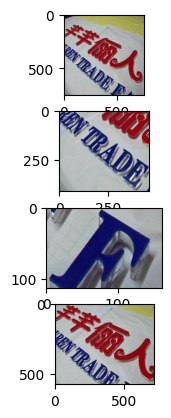

done


In [1]:
import os
import numpy as np

from matplotlib import pyplot as plt

# Load file name list, PATH should be the filepath of the folder containing the txt files
def load_file_names(path):
    # we load a list of all the file names in the path, then truncate to remove the file extension
    temp = os.listdir(path)    
    for i in range(0, len(temp)):
        temp[i] = temp[i][:-4]
        # now we gotta get rid of the 
    return temp

# Get the text and image data of a file name, returned as a tuple, make sure the encoding is right....
def get_text_image(txt_path, jpeg_path, file_name):
    # Grab the raw text data of the txt
    with open(txt_path + "/" + file_name + ".txt","r", encoding='utf-8') as text_file:
        text = text_file.readlines()
    # Grab the jpeg as a 3D numpy Array
    jpeg = plt.imread(jpeg_path + "/" + file_name + ".jpg", ".jpg")
    try:
        if len(jpeg) == 0:
            print(f"error reading jpeg name {jpeg_path}")
    except:
        print(f"error reading jpeg.... {jpeg_path} + {file_name}")
        print("full path: " + jpeg_path + "/" + file_name + ".jpg")
        print(jpeg)
    return (text, jpeg)

# Given an image and the respective text data, extract the image data of interest, The return data will look like so...
# Array of tuples, each tuple is of length two with [0] being the image data, and [1] being the text
def extract_relevant_data(text, image):
    ret = []
    img_height, img_width, _ = image.shape 
    # For each line denoting relevant data...
    for line in text:

        # We first need to ignore entries without any kanji data.
        # We ignore this step for now
        if "#" in line:
            continue
        # split the line into a, array
        split_line = line.strip().split(",")
        # every split line should be exactly 9 entries long, with the last being the actual text data...
        x1 = round(float(split_line[0]))
        y1 = round(float(split_line[1]))
        x2 = round(float(split_line[2]))
        y2 = round(float(split_line[3]))
        x3 = round(float(split_line[4]))
        y3 = round(float(split_line[5]))
        x4 = round(float(split_line[6]))
        y4 = round(float(split_line[7]))
        actual_text = ""
        for start_index in range(8, len(split_line)):
            actual_text += split_line[8]
            if start_index+1 < len(split_line):
                actual_text += ","

        top_y = min(y1, y2, y3, y4)
        left_x = min(x1, x2, x3, x4)
        right_x = max(x1, x2, x3, x4)
        bottom_y = max(y1, y2, y3, y4)

        top_y = max(top_y, 0)
        left_x = max(left_x, 0)
        right_x = min(right_x, img_width)
        bottom_y = min(bottom_y, img_height)

        # Extract the image data around x1, y1, x2, y2, x3, y3, x4, y4
        x_image = image[top_y:bottom_y, left_x:right_x]
        #transpose = np.transpose(x_image)
        #y_extract = transpose.tolist()[left_x:right_x]
        #final_image = np.transpose(y_extract)
        ret.append((actual_text, x_image))
        
        #print(x_image)
        #y_image = x_image
        
    return ret

print("starting...")
top_path = "/home/ec2-user/.jupyter/782_project/input_data_raw/mtwi_train/txt_train"
files = load_file_names(top_path)
#print(files)
txt_path = "/home/ec2-user/.jupyter/782_project/input_data_raw/mtwi_train/txt_train"
jpeg_path = "/home/ec2-user/.jupyter/782_project/input_data_raw/mtwi_train/image_train"

# get and display the first image, alone with the text that comes w it
text, image = get_text_image(txt_path, jpeg_path, files[0])

#for file in files:
#    print(file)

print(text)
#print(image)


final_images = extract_relevant_data(text, image)
tt, ii = get_text_image(txt_path, jpeg_path, "T13PYoFtxeXXXXXXXX_!!0-item_pic.jpg")
image_interest = extract_relevant_data(tt, ii)
print(len(final_images))
print(final_images[0][1].shape)

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(ii)
axarr[1].imshow(image_interest[0][1])
axarr[2].imshow(image_interest[1][1])
axarr[3].imshow(image_interest[2][1])
#axarr[3].imshow(v_slice[3])


plt.show()

print("done")

## Create the SFCs

In [2]:
from hilbert import decode, encode
import zCurve as z

import numpy as np
import math
import time
import copy

def generate_intersecting_locs_hilbert(data_numpy_2d, stride = 2, kernel_size = 8):
    height, width, _ = data_numpy_2d.shape
    num_bits = int(math.ceil(math.log(kernel_size, 2)))
    if min(width, height) < kernel_size:
        return None
    offset_x = 0
    offset_y = 0
    # Basically, we make the SFC, then we copy it and iterate the values based on whats in the offset
    loc_arr = [None] * (kernel_size * kernel_size)
    count_x = 0
    count_y = 0
    for i in range(0, len(loc_arr)):
        loc_arr[i] = [count_y, count_x]
        #print(loc_arr[i])
        count_y += 1
        if count_y >= kernel_size:
            count_y = 0
            count_x += 1
    #zcurve_ints = []
    #print(loc_arr)
    numpy_loc_arr = np.array(loc_arr)
    hilbert_ints = encode(numpy_loc_arr, 2, num_bits)
    #print(zcurve_ints)
    #for zint in zcurve_ints:
        #print(format(zint, "b"))
    sorted_hilbert = np.sort(hilbert_ints)
    hilbert_locs = decode(sorted_hilbert, 2, num_bits)
    #print(zcurve_locs)
    final_array = []
    while True:
        # Here, we continually iterate the zcurve locs array, building the final array
        for location in hilbert_locs:
            final_array.append((location[0] + offset_y, location[1] + offset_x))
        offset_y += stride
        if offset_y + kernel_size > height:
            offset_y = 0
            offset_x += stride
            if offset_x + kernel_size > width:
                break
    return final_array

def generate_intersecting_locs(data_numpy_2d, stride = 2, kernel_size = 8):
    height = data_numpy_2d.shape[0]
    width = data_numpy_2d.shape[1]
    num_bits = int(math.ceil(math.log(kernel_size, 2)))
    if min(width, height) < kernel_size:
        return None
    offset_x = 0
    offset_y = 0
    # Basically, we make the SFC, then we copy it and iterate the values based on whats in the offset
    loc_arr = [None] * (kernel_size * kernel_size)
    count_x = 0
    count_y = 0
    for i in range(0, len(loc_arr)):
        loc_arr[i] = [count_y, count_x]
        #print(loc_arr[i])
        count_y += 1
        if count_y >= kernel_size:
            count_y = 0
            count_x += 1
    zcurve_ints = []
    #print(loc_arr)
    for y, x in loc_arr:
        # WHY DONT YOU WORKIE
        zcurve_ints.append(z.interlace(y, x, dims = 2, bits_per_dim = num_bits))
    #print(zcurve_ints)
    #for zint in zcurve_ints:
        #print(format(zint, "b"))
    zcurve_ints.sort()
    zcurve_locs = []
    for z_int in zcurve_ints:
        zcurve_locs.append(z.deinterlace(z_int, 2))
    #print(zcurve_locs)
    final_array = []
    while True:
        # Here, we continually iterate the zcurve locs array, building the final array
        for location in zcurve_locs:
            final_array.append((location[0] + offset_y, location[1] + offset_x))
        offset_y += stride
        if offset_y + kernel_size > height:
            offset_y = 0
            offset_x += stride
            if offset_x + kernel_size > width:
                break
    return final_array
            
def generate_horizontal_snake_locs(data_numpy_2d):
    ret = []
    width, height, _ = data_numpy_2d.shape
    loc_y = 0
    loc_x = 0
    # go right, then up, then left
    while loc_y < height:
        while loc_x < width:
            ret.append([loc_y, loc_x])
            loc_x += 1
        loc_x -= 1
        loc_y += 1
        if loc_y >= height:
            break
        while loc_x >= 0:
            ret.append([loc_y, loc_x])
            loc_x -= 1
        loc_x +=1
        loc_y +=1
    return ret

def generate_vertical_snake_locs(data_numpy_2d):
    ret = []
    height, width, _ = data_numpy_2d.shape
    loc_y = 0
    loc_x = 0
    # go up, then right, then down, go right and repeat until loc_x is OOB
    while loc_x < width:
        while loc_y < height:
            ret.append([loc_y, loc_x])
            loc_y += 1
        loc_y -= 1
        loc_x += 1
        if loc_x >= width:
            break
        while loc_y >= 0:
            ret.append([loc_y, loc_x])
            loc_y -= 1
        loc_y += 1
        loc_x += 1
    return ret

# Assume we have final_images
def generate_hilbert_locs(data_numpy_2d):
    # we have an image of arbitrary size
    # we grab the larger dimension, use the rounded up log as the number of bits
    size_y = data_numpy_2d.shape[0]
    size_x = data_numpy_2d.shape[1]
    larger = max(size_x, size_y)
    num_bits = int(math.ceil(math.log(larger, 2)))

    #now we build the loc array, which we will encode, sort, then decode
    loc_arr = [None] * (size_y * size_x)
    count_x = 0
    count_y = 0
    for i in range(0, len(loc_arr)):
        loc_arr[i] = [count_y, count_x]
        #print(loc_arr[i])
        count_y += 1
        if count_y >= size_y:
            count_y = 0
            count_x += 1
    numpy_loc_arr = np.array(loc_arr)
    hilbert_ints = encode(numpy_loc_arr, 2, num_bits)
    # Sort the hilbert_ints array
    sorted_hilbert = np.sort(hilbert_ints)
    #print(sorted_hilbert)
    # now we decode
    hilbert_locs = decode(sorted_hilbert, 2, num_bits)
    #print(hilbert_locs)
    return hilbert_locs

def generate_zcurve_locs(data_numpy_2d):
    # we have an image of arbitrary size
    # we grab the larger dimension, use the rounded up log as the number of bits
    size_y = data_numpy_2d.shape[0]
    size_x = data_numpy_2d.shape[1]
    larger = max(size_x, size_y)
    num_bits = int(math.ceil(math.log(larger, 2)))

    #now we build the loc array, which we will encode, sort, then decode
    loc_arr = [None] * (size_y * size_x)
    count_x = 0
    count_y = 0
    for i in range(0, len(loc_arr)):
        loc_arr[i] = [count_y, count_x]
        #print(loc_arr[i])
        count_y += 1
        if count_y >= size_y:
            count_y = 0
            count_x += 1
    zcurve_ints = []
    for y, x in loc_arr:
        zcurve_ints.append(z.interlace(y, x, dims = 2, bits_per_dim = num_bits))
    zcurve_ints.sort()
    zcurve_locs = []
    for z_int in zcurve_ints:
        zcurve_locs.append(z.deinterlace(z_int, 2))
    return zcurve_locs
    
# returns the image data as a 1d + 3 color channel array
def transform_to_1d(hilbert_path, image_data):
    flat_r = [] 
    flat_g = []
    flat_b = [] 
    curr_index = 0
    for loc_y, loc_x in hilbert_path:
        flat_r.append(image_data[loc_y][loc_x][0])
        flat_g.append(image_data[loc_y][loc_x][1])
        flat_b.append(image_data[loc_y][loc_x][2])
        
    return (flat_r, flat_g, flat_b)

def transform_to_1d_no_rgb(hilbert_path, image_data):
    flattened_image = []
    curr_index = 0
    for loc_y, loc_x in hilbert_path:
        flattened_image.append(int(image_data[loc_y][loc_x] * 255))
    return flattened_image
    

def calc_min_loss(path_arr, search_distance, tresh_distance, img_width, img_height):

    # Get adjacent elements for all entries in the image
    def get_adjacent_elements(path_arr, width):
        ret = {}
        # for each SFC in the path_arr
        for path in path_arr:
            # we iterate through each element
            for start in range(0, len(path)):
                loc_y, loc_x = path[start]
                # we use loc_y and loc_x in place of path
                if f"{loc_y},{loc_x}" not in ret:
                    ret[f"{loc_y},{loc_x}"] = {}
                    
                for i in range(max(start-width-1, 0), start):
                    ret[f"{loc_y},{loc_x}"][f"{path[i][0]},{path[i][1]}"] = 0
                    
                for i in range(start+1, min(start+width+1, len(path))):
                    ret[f"{loc_y},{loc_x}"][f"{path[i][0]},{path[i][1]}"] = 0
                
        return ret
    adj_time = 0
    test_time = 0        
    running_average = 0
    percent_done = 0.1
    adj_s = time.time()
    adjacent_elements = get_adjacent_elements(path_arr, search_distance)
    adj_e = time.time()
    adj_time += adj_e - adj_s
    
    for i in range(0, len(path_arr[0])):
        loc_y, loc_x = path_arr[0][i]
        if i/len(path_arr[0]) >= percent_done:
            print(f"{i}/{len(path_arr[0])}")
            percent_done += 0.1

        width = min(loc_x + tresh_distance, img_width) - max(loc_x - tresh_distance, 0) + 1
        height = min(loc_y + tresh_distance, img_height) - max(loc_y - tresh_distance, 0) + 1
        size = width*height
        # Now we count how many unique elements within tresh_distance of the loc_x/y we encounter, divide by size to get a percentage of visited pixels
        curr_avg = 1
        test_s = time.time()
        for element in adjacent_elements[f"{loc_y},{loc_x}"]:
            es_y, es_x = element.split(",")
            try:
                element_y = int(es_y)
                element_x = int(es_x)
            except ValueError:
                element_y = int(float(es_y))
                element_x = int(float(es_x))
            #print(f"{element_y}, {element_x}")
            if element_y >= loc_y - tresh_distance and element_y <= loc_y + tresh_distance:
                if element_x >= loc_x - tresh_distance and element_x <= loc_x + tresh_distance:
                    curr_avg += 1
        test_end = time.time()
        test_time += test_end - test_s
        curr_avg /= size
        running_average += curr_avg
    running_average /= len(path_arr[0])
    return (running_average, test_time, adj_time)

path_arr = []
#hilbert_path = generate_hilbert_locs(final_images[0][1])
#horiz_path = generate_horizontal_snake_locs(final_images[0][1])
#vert_path = generate_vertical_snake_locs(final_images[0][1])
zcurve_path = generate_zcurve_locs(final_images[0][1])

#print("ZCURVE THAT HOE")
#for loc in zcurve_path:
   # print(loc)

#print(len(hilbert_path))
#print(len(horiz_path))
#print(len(vert_path))
#print(len(zcurve_path))

#path_arr.append(hilbert_path)
#path_arr.append(horiz_path)
#path_arr.append(vert_path)
#path_arr.append(zcurve_path)
hilbert_path = generate_intersecting_locs(final_images[0][1], 2, 8)
path_arr.append(hilbert_path)
print(len(hilbert_path))
print(final_images[0][1].shape)
#for loc in hilbert_path:
    #print(loc)

flat_r, flat_g, flat_b = transform_to_1d(hilbert_path, final_images[0][1])

img_height = final_images[0][1].shape[0]
img_width = final_images[0][1].shape[1]
#start_time = time.time()
#loss, test_time, adjs_time = calc_min_loss(path_arr, 6, 6, img_width, img_height)
#end_time = time.time()
#print(loss)
#print(f"done in {end_time-start_time} seconds... adj time is {adjs_time} sec... test time is {test_time} sec.")
grid_search_kernels = [2, 3, 4, 5, 6, 7]
grid_search_strides = [1, 2, 3, 4]
results = []
print("starting grid!")
#
#for kernel in grid_search_kernels:
#    for stride in grid_search_strides:
#        if stride >= kernel:
#            continue
#        path_arr = [] 
#        output = generate_intersecting_locs(final_images[0][1], stride, kernel)
#        path_arr.append(output)
#        loss, _, _ = calc_min_loss(path_arr, 6, 6, img_width, img_height)
#        kern_copy = copy.deepcopy(kernel)
#        stride_copy = copy.deepcopy(stride)
#        results.append([loss, kern_copy, stride_copy])
#        print(f"Finished kern: {kernel}, stride: {stride}, loss: {loss}")
print(results)



#done in 514.1358368396759 seconds
#done in 585.1955156326294 seconds... adj time is 575.9581654071808 sec... test time is 7.713170528411865 sec.
# Do some test calls to make sure we understand the code
#hilbert_locs = np.array([[0,0], [1,0], [0,2], [0,3], [0,1],[1,1],[1,2],[1,3]])
#hil_ints = encode(hilbert_locs,2,3)
#print(hil_ints)
#locs = decode(np.array([0,1,2,3,4,5,6,7]), 2, 3)
#print(locs)
# 0.3335247366609943
# 0.8520837153254096 with 240, 6
# ---== INTERSECTING ==---
# 0.14 with 11, 11, stride 2, z curve --all below are 8x8 kernel--
# 0.3 with 22, 11 stride 2, z curve
# 0.26 with 22, 11 stride 3, z curve
# with 11, 11 stride 1, z curve
# 0.39052285360156996 with 11, 6 stride 2, z curve
# 0.8325782210424191 with 22, 6 stride 2, z curve
# 0.34611157745392407 with 6, 6 stride 1, z curve
# 0.226632144347659 with 6, 6 stride 2, z curve
# 0.22584590336449661 with 6, 6, stride 2, zcurve, 16x16 kernel
# 0.43632746544299356 with 22, 6 stride 4 , zcurve 16x16 kernel
# 0.5786743002779551 with 32, 6 stride 4, zcurve 16x16 kernel
#-- going back to 8x8, stride 2
# 0.9293439119127298 with 32, 6 stride 2, zcurve 8x8
# 0.6128311556329077 with 30, 6 stride 2, zcurve 6x6
# 0.5371472462887548 with 30, 6 stride 3, zcurve 6x6
# 0.4331566475477195 with 30, 6 stride 5, zcruve 6x6

# best so far is [0.3023125573812018, 7, 2]

441792
(84, 361, 3)
starting grid!
[]


## Apply ROCKET kernels to transformed data

In [ ]:
#https://github.com/sktime/sktime/blob/main/examples/transformation/rocket.ipynb
#https://github.com/sktime/sktime/blob/main/sktime/transformations/panel/rocket/_rocket.py
# Apply rocket transformations one at a time, as the various channels do not have any special relationship to each other.
# Maybe use multivariate with something like normalized RGB or HSV
# We will just collapse the RGB into greyscale



# we should train with a neural network afterwards

In [6]:
grid_search_params_out = open("./gsp_3_hilberts_out.txt","w")
grid_search_params_out.write(f"{results}")
grid_search_params_out.close()

## Format input data

In [4]:
import pandas as pd



# We need to take all of the text "classes" from our input data and create a one-hot vector encoding for it.
print("starting...")
top_path = "/home/ec2-user/.jupyter/782_project/input_data_raw/mtwi_train/txt_train"
files = load_file_names(top_path)
# go into each of the text files, grab the text content (drop the # entries)
txt_path = "/home/ec2-user/.jupyter/782_project/input_data_raw/mtwi_train/txt_train"
jpeg_path = "/home/ec2-user/.jupyter/782_project/input_data_raw/mtwi_train/image_train"


# two arrays we build while we iterate
name_col = []
content_arr = []

for file in files:
    #try:
    text_arr, _ = get_text_image(txt_path, jpeg_path, file)
    curr_count = 0
    #print(text_arr)
    for index in range(0, len(text_arr)):
        messy_text = text_arr[index].split(",")[8:]
        clean_text = ""
        for j_index in range(0, len(messy_text)):
            clean_text += messy_text[j_index]
            if j_index + 1 < len(messy_text):
                clean_text += ","
        clean_text = clean_text.strip()
        if "#" in clean_text:
            continue
        name_col.append(f"{curr_count}:{file}")
        token_arr = []
        for string_index in range(0, len(clean_text)):
            token_arr.append(clean_text[string_index])
        content_arr.append(token_arr)
        #print(token_arr)
        curr_count += 1
        #print(clean_text)
        #print(messy_text)
    #except:
        #print(f"big error at file {file}")

print(len(name_col))
print(len(content_arr))

# start a dataframe that we append all of the data to


starting...
144077
144077


In [ ]:
# now, we make the dataframe set the row names, and save it as a csv 
raw_frame = pd.DataFrame(content_arr, index = name_col)
print(raw_frame)
raw_frame.to_csv("./class_data.csv", encoding = "utf-8")

In [5]:
# see if we can read the csv
import pandas as pd
csv_path = "./class_data_fixed.csv"
class_dataframe = pd.read_csv(csv_path, dtype = str)
row_names = class_dataframe["Unnamed: 0"]
class_dataframe = class_dataframe.drop(labels = "Unnamed: 0", axis = 1)

In [6]:
print(class_dataframe)
print(len(row_names))

                          0
0                      薄利汽配
1              五菱荣光前外拉手颜色齐全
2                      80ml
3               *小宅屋*专用盗图可耻
4       DERMATOLOGISTTESTED
...                     ...
144072                 ug/㎡
144073                 ug/㎡
144074                 60.8
144075                PM2.5
144076              PureAir

[144077 rows x 1 columns]
144077


In [ ]:
transformed_dataframe.to_csv("./class_data_one_hot.csv")

In [7]:
#print(class_dataframe)
from sklearn.feature_extraction.text import CountVectorizer
# drop the unnamed column as the row names (important to preserve for mapping to the images and indecies)

#print(row_names)
#print(class_dataframe)
class_as_series = class_dataframe["0"].astype(dtype = str)
print(class_as_series)
vectorizer = CountVectorizer(lowercase = False, analyzer = "char", binary = True)
vectorizer = vectorizer.fit(class_as_series)

0                        薄利汽配
1                五菱荣光前外拉手颜色齐全
2                        80ml
3                 *小宅屋*专用盗图可耻
4         DERMATOLOGISTTESTED
                 ...         
144072                   ug/㎡
144073                   ug/㎡
144074                   60.8
144075                  PM2.5
144076                PureAir
Name: 0, Length: 144077, dtype: object


In [ ]:
transformed = vectorizer.transform(class_as_series)
dense_transformed = transformed.todense()
print("----DENSE BELOW----")
print(dense_transformed)
print(class_dataframe)
print(transformed)
col_names = vectorizer.get_feature_names_out()
print(col_names)
print(col_names)
transformed_dataframe = pd.DataFrame(dense_transformed, index = row_names, columns = col_names, dtype = int)
transformed_dataframe.to_csv("./class_data_one_hot.csv")
print(transformed_dataframe)

In [5]:
splits = np.array_split(files, 5)

In [8]:
# Once this is done, we want to split the names array and then make our splits from that.
#print(files)
files = load_file_names(top_path)
splits = np.array_split(files, 5)
#print(splits)

dataframe_array = [None] * 5

# now we go through each split, build the dataframe, transform with our vectorizer, and add it to the dataframe array
split_count = 0
col_names = vectorizer.get_feature_names_out()
#print(splits)
for split in splits:
    content_arr = []
    name_col = []
    print(split)
    print(len(split))
    currindex = 0
    for file in split:
        # for each file, we do the operations that built the array in the first step...
        #print(txt_path)
        #print(jpeg_path)
        #print(file)
        text_arr, _ = get_text_image(txt_path, jpeg_path, file)
        curr_count = 0
        #print(text_arr)
        for index in range(0, len(text_arr)):
            messy_text = text_arr[index].split(",")[8:]
            clean_text = ""
            for j_index in range(0, len(messy_text)):
                clean_text += messy_text[j_index]
                if j_index + 1 < len(messy_text):
                    clean_text += ","
            clean_text = clean_text.strip()
            if "#" in clean_text:
                continue
            name_col.append(f"{curr_count}:{file}")
            content_arr.append(clean_text)
            #print(token_arr)
            curr_count += 1
        currindex += 1
        #print(currindex)
        pass
        # now we print this one to make sure its good
    #print(name_col)
    #print(content_arr)
    # if it works like we think it does....
    # we transform the content array to a new dataframe
    split_frame = pd.DataFrame(content_arr, index = name_col)
    class_as_series = split_frame[0].astype(dtype = str)
    # send it through the vectorizer
    # save it
    vector_frame = vectorizer.transform(class_as_series).todense()
    final_frame = pd.DataFrame(vector_frame, index = name_col, columns = col_names)
    #print(final_frame)
    print(final_frame.shape)
    final_frame.to_csv(f"split_{split_count}.csv")
    split_count += 1
    pass
    

['T1.3BPFFJdXXXXXXXX_!!0-item_pic.jpg' 'T1.AK_XX8hXXbnu_Z1_042512.jpg'
 'T1.jN7XvpiXXXXXXXX_!!0-item_pic.jpg' ... 'TB1BG0CLXXXXXXtXVXXunYpLFXX'
 'TB1bg0SLXXXXXbwXXXXunYpLFXX' 'TB1bG80LpXXXXaIaXXXunYpLFXX']
2010
(28306, 4528)
['TB1bG8zLXXXXXaXXVXXunYpLFXX' 'TB1BgDDOFXXXXcvaFXXfUtEFFXX'
 'TB1bGFJLXXXXXcSXpXXunYpLFXX' ... 'TB1iK4KLXXXXXbOXpXXunYpLFXX'
 'TB1Ik4KLXXXXXcPXpXXunYpLFXX' 'TB1ikFoLXXXXXaiapXXunYpLFXX']
2010
(28374, 4528)
['TB1iKNtLXXXXXbXaXXXunYpLFXX' 'TB1iKRVLpXXXXXeapXXunYpLFXX'
 'TB1ikxOLXXXXXXRXpXXunYpLFXX' ... 'TB1qUFQLXXXXXbgXXXXunYpLFXX'
 'TB1QUJsLXXXXXbNaXXXunYpLFXX' 'TB1QUNMLXXXXXa7XpXXunYpLFXX']
2010
(29337, 4528)
['TB1qUpOLXXXXXc0XXXXunYpLFXX' 'TB1qUtvLXXXXXX9aXXXunYpLFXX'
 'TB1quWndwfH8KJjy1zcXXcTzpXa_!!0-item_pic.jpg' ...
 'TB1ZW8_LpXXXXcbXFXXunYpLFXX' 'TB1zWhzLXXXXXbyXVXXunYpLFXX'
 'TB1zWJmLXXXXXasXFXXunYpLFXX']
2009
(28762, 4528)
['TB1zWNALXXXXXaZXVXXunYpLFXX' 'TB1zwpLLXXXXXaYXpXXunYpLFXX'
 'TB1ZWRTLXXXXXblXXXXunYpLFXX' ...
 'TB2_TQkeF5N.eBjSZFvXXbvMFXa_!!30125467

In [32]:
curr_split = 0
for split in splits:
    f_out = open(f"files_split_{curr_split}.txt","w")
    for file in split:
        f_out.write(file + "\n")
    f_out.close()
    curr_split += 1

In [12]:
from sktime.transformations.panel.rocket import MultiRocket
import time
# We wanna init the multirocket kernel
# We want two splits for the zcurve (5, 3) and hilbert curve (7, 2)
# we also want the splits to be preserved

txt_path = "/home/ec2-user/.jupyter/782_project/input_data_raw/mtwi_train/txt_train"
jpeg_path = "/home/ec2-user/.jupyter/782_project/input_data_raw/mtwi_train/image_train"

rocket = MultiRocket(random_state = 42, num_kernels = 1250, n_jobs = -1)

file_finish_counter = 0
file_split_counter = 0
fitted = False
for split in splits:
    split_start_time = time.time()
    name_col = []
    content_arr = None
    print(len(split))
    if fitted and (file_split_counter == 0 or file_split_counter == 1):
        print(f"Skipping split {file_split_counter}")
        file_split_counter += 1
        continue
    for file in split:
        # we load the file
        text, image = get_text_image(txt_path, jpeg_path, file)
        partitioned_images = extract_relevant_data(text, image)
        curr_part_index = 0
        #print(partitioned_images)
        for part_text, part_image in partitioned_images:
            # transform the image to 1D 
            #print(len(part_image[0]))
            #print(len(part_image))
            part_image_flattened = generate_intersecting_locs(part_image, 3, 5)
            if part_image_flattened is None:
                curr_part_index += 1
                continue
            #print(len(part_image_flattened))
            #print(part_image_flattened)
            #print(part_image_flattened)
            #print("flattening...")
            part_image_r, part_image_g, part_image_b = transform_to_1d(part_image_flattened, part_image)
            if not fitted:
                dummy_arr = np.array([[part_image_r[:500], part_image_g[:500], part_image_b[:500]]])
                #print("fitting...")
                rocket.fit(dummy_arr)
                fitted = True
                break
            #print("transforming...")
            transformed_r = rocket.transform(np.array([[part_image_r, part_image_g, part_image_b]]))
            if content_arr is None:
                transformed_r = transformed_r.rename(index = {0:f"{curr_part_index}:{file}"})
                #print(transformed_r.index.tolist()[0])
                #print(type(transformed_r.index.tolist()[0]))
                content_arr = transformed_r
            else:
                transformed_r = transformed_r.rename(index = {0:f"{curr_part_index}:{file}"})
                content_arr = pd.concat([content_arr, transformed_r])
            # We transform the image with the multirocket kernel
            curr_part_index += 1
        if file_finish_counter % 200 == 0: 
            print(f"finished {file_finish_counter}")
        if file_split_counter == 0 or file_split_counter == 1:
            break
        #print(content_arr)
        file_finish_counter += 1
    # build the dataframe and save it
    if file_split_counter == 0 or file_split_counter == 1:
        print(f"Skipping split {file_split_counter}")
        file_split_counter += 1
        continue
    split_end_time = time.time()
    print(f"Split ended in {split_end_time - split_start_time} seconds")
    content_arr.to_csv(f"split_{file_split_counter}_features.csv")
    file_split_counter += 1

#Split ended in 24758.016056537628 seconds
    
#Split ended in 25942.77943611145 seconds
#Split ended in 14197.2523458004 seconds

#Split ended in 14018.719998598099 seconds

#Split ended in 18137.51794552803 seconds

2010
finished 0
Skipping split 0
2010
Skipping split 1
2010
finished 0
finished 200
finished 400
finished 600
finished 800
finished 1000
finished 1200
finished 1400
finished 1600
finished 1800
finished 2000
Split ended in 14197.2523458004 seconds
2009
finished 2200
finished 2400
finished 2600
finished 2800
finished 3000
finished 3200
finished 3400
finished 3600
finished 3800
finished 4000
Split ended in 14018.719998598099 seconds
2009
finished 4200
finished 4400
finished 4600
finished 4800
finished 5000
finished 5200
finished 5400
finished 5600
finished 5800
finished 6000
Split ended in 18137.51794552803 seconds


In [6]:
# We need to load the class and feature data, select only the class data that remains in the feature frame
import pandas as pd

#init the paths
files = [("./split_0_features.csv","./split_0.csv","./split_0_fixed.csv"), ("./split_1_features.csv","./split_1.csv","./split_1_fixed.csv"), ("./split_2_features.csv","./split_2.csv","./split_2_fixed.csv"), ("./split_3_features.csv","./split_3.csv","./split_3_fixed.csv"), ("./split_4_features.csv","./split_4.csv","./split_4_fixed.csv")]
for feature_file, split_file, new_file in files:
    # We open the feature and split files

    feature_frame = pd.read_csv(feature_file)
    split_frame = pd.read_csv(split_file)


    feature_map = feature_frame.loc[:, "Unnamed: 0"]
    #split_map = split_frame.loc[:,"Unnamed: 0"]
    
    #feature_frame.drop("Unnamed: 0", axis = 1, inplace = True)
    #split_frame.drop("Unnamed: 0", axis = 1, inplace = True)

    fixed_split_map = split_frame[split_frame["Unnamed: 0"].isin(feature_map)]
    
    #print(f"Feature Frame len: {feature_frame.shape[0]}, Split Frame len {split_frame.shape[0]}")
    #print(feature_frame)
    #print(split_frame)
    #print(feature_map)
    #print(fixed_split_map)
    #print(f"Fixed split len: {fixed_split_map.shape[0]}")

    fixed_split_map.reset_index(drop=True, inplace = True)

    fixed_split_map.to_csv(new_file, index = False)


In [5]:
    fixed_split_map = split_frame[split_frame["Unnamed: 0"].isin(feature_map)]
    
    print(f"Feature Frame len: {feature_frame.shape[0]}, Split Frame len {split_frame.shape[0]}")
    print(feature_frame)
    print(split_frame)
    print(feature_map)
    print(fixed_split_map)
    print(f"Fixed split len: {fixed_split_map.shape[0]}")

Feature Frame len: 28215, Split Frame len 28306
                                  Unnamed: 0  var_0__0  var_0__1  var_0__2  \
0      0:T1.3BPFFJdXXXXXXXX_!!0-item_pic.jpg  0.395680  0.712618  0.142770   
1      1:T1.3BPFFJdXXXXXXXX_!!0-item_pic.jpg  0.406313  0.714667  0.099156   
2            0:T1.AK_XX8hXXbnu_Z1_042512.jpg  0.465455  0.643636  0.203636   
3            1:T1.AK_XX8hXXbnu_Z1_042512.jpg  0.320167  0.873100  0.063672   
4            2:T1.AK_XX8hXXbnu_Z1_042512.jpg  0.475926  0.626667  0.248519   
...                                      ...       ...       ...       ...   
28210          2:TB1bG80LpXXXXaIaXXXunYpLFXX  0.445714  0.634286  0.170794   
28211          3:TB1bG80LpXXXXaIaXXXunYpLFXX  0.448889  0.568254  0.286984   
28212          4:TB1bG80LpXXXXaIaXXXunYpLFXX  0.372698  0.866032  0.011429   
28213          5:TB1bG80LpXXXXaIaXXXunYpLFXX  0.420000  0.533333  0.260000   
28214          6:TB1bG80LpXXXXaIaXXXunYpLFXX  0.455789  0.667368  0.220000   

       var_0__3

In [1]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import time
import gc

validation_splits = [((0,1,2,3),(4)), ((0,1,2,4),(3)), ((0,1,3,4),(2)), ((0,2,3,4),(1)), ((1,2,3,4),(0))]
NN_avgs = []

split_list = [0,1,2,3,4]
classes = None
num_classes = None
whole_train_features = []
whole_train_class = []
for split in split_list:
    # Load the feature and class data...
    feature_frame = pd.read_csv(f"./multi_dataset/split_{split}_features.csv").drop("Unnamed: 0", axis = 1)
    class_frame = pd.read_csv(f"./multi_dataset/split_{split}_fixed.csv").drop("Unnamed: 0", axis = 1)
    if classes is None:
        classes = class_frame.columns.to_list()
        num_classes = np.arange(0, len(classes), 1)
        print(len(classes))
        print(num_classes)
    whole_train_features.append(feature_frame.to_numpy())
    whole_train_class.append(class_frame.to_numpy()) 
    feature_frame = None
    class_frame = None
    gc.collect()
    print(f"Finished loading split {split} in {split_list}")

4528
[   0    1    2 ... 4525 4526 4527]
Finished loading split 0 in [0, 1, 2, 3, 4]
Finished loading split 1 in [0, 1, 2, 3, 4]
Finished loading split 2 in [0, 1, 2, 3, 4]
Finished loading split 3 in [0, 1, 2, 3, 4]
Finished loading split 4 in [0, 1, 2, 3, 4]


In [14]:
from sklearn.metrics import multilabel_confusion_matrix
#print(classes)
print(len(classes))
#print(whole_train_class[4])
#print(predicted)
'''
for row in range(0, len(predicted)):
    for index in range(0, len(predicted[row])):
        if whole_train_class[4][row][index] == 1:
            if predicted[row][index] == 1:
                print("match!")
'''

for row in range(0, len(predicted)):
    for index in range(0, len(predicted[row])):
        if predicted[row][index] == 1:
            print("found a 1")
        pass
#print(classification_report(whole_train_class[valid_split], predicted, labels = num_classes))

4528


In [6]:
print("Finished loading frame, training NN")

from sklearn.metrics import classification_report

class_reports = []

for train_split, valid_split in validation_splits:

  
    classifier = MLPClassifier(hidden_layer_sizes=(1,), random_state = 42)
    fit_start_time = time.time()
    classes_fit = False
    for i in train_split:    
        if not classes_fit:
            classifier.partial_fit(whole_train_features[i], whole_train_class[i], classes = num_classes)
            classes_fit = True
        else:
            classifier.partial_fit(whole_train_features[i], whole_train_class[i])
    fit_end_time = time.time()
    print(f"Total Training Time: {fit_end_time-fit_start_time} seconds")
    predicted = classifier.predict(whole_train_features[valid_split])

    error_arr = []
    y_index = 0

    # Calc the classification report....
    report_calc_start = time.time()
    class_reports.append(classification_report(whole_train_class[valid_split], predicted, labels = classes))
    report_calc_end = time.time()
    print(f"Classification Report done in {report_calc_end - report_calc_start} seconds.")
    
#    for row in predicted:
#        num_errors = 0
#        for i in range(0, len(row)):
#            if not row[i] == whole_train_class[4][y_index][i]:
#                num_errors += 1
#        error_arr.append(num_errors)
#        y_index += 1
#    #print(error_arr)
#    total_sum = 0
#    for num in error_arr:
#        total_sum += num
#    total_sum /= len(error_arr)
#    print(total_sum)

#Total Training Time: 48.46670699119568 seconds
#4.361349420651468
#Total Training Time: 46.801013469696045 seconds
#4.360291553323568
#Total Training Time: 47.8180832862854 seconds
#4.361260305839691
#Total Training Time: 49.98047876358032 seconds
#4.3578727767759275
#Total Training Time: 47.44742012023926 seconds
#4.359276980329612
#https://datasets.activeloop.ai/docs/ml/datasets/kuzushiji-kanji-kkanji-dataset/

Finished loading frame, training NN
Total Training Time: 29.658361673355103 seconds


UFuncTypeError: ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U21'), dtype('<U21')) -> None

In [17]:
predicted = classifier.predict(whole_train_features[4])
#print(predicted)
#print(whole_train_class[4])
error_arr = []
y_index = 0
for row in predicted:
    num_errors = 0
    for i in range(0, len(row)):
        if not row[i] == whole_train_class[4][y_index][i]:
            num_errors += 1
    error_arr.append(num_errors)
    y_index += 1
#print(error_arr)
total_sum = 0
for num in error_arr:
    total_sum += num
total_sum /= len(error_arr)
print(total_sum)

4.361349420651468


### KKANJI2 DATASET

In [39]:
import os
from sktime.transformations.panel.rocket import MultiRocket
import time
from matplotlib import pyplot as plt
import numpy as np

#
dataset_path = "./kuzushiji-dataset/kkanji2"
folders = os.listdir(dataset_path)
#print(folders)

file_array = []

# WE START BY MAKING THE SPLITS
for folder in folders:
    # For fun, convert the name to the character and print
    #print(chr(int(folder[2:], 16)))
    char_name = str(chr(int(folder[2:], 16)))

    for image_path in os.listdir(dataset_path + "/" + folder):
        file_array.append(f"{dataset_path + '/' + folder + '/' + image_path},{char_name}")

shuffle = np.array(file_array)
np.random.shuffle(shuffle)
splits = np.array_split(shuffle, 5)
for index in range(0, len(splits)):
    out_split = open(f"./single_dataset/single_split_{index}", "w")
    for item in splits[index]:
        out_split.write(f"{item}\n")
    out_split.close()


In [ ]:
import os
from sktime.transformations.panel.rocket import MultiRocket
import time
from matplotlib import pyplot as plt
import pandas as pd

#
dataset_path = "./kuzushiji-dataset/kkanji2"
folders = os.listdir(dataset_path)
#print(folders)
class_dict = {}

fitted = False

rocket = MultiRocket(random_state = 42, num_kernels = 1250, n_jobs = -1)


file_split_counter = 0

# Build our split arrays
feature_splits = []
class_splits = []

for index in range(0, len(splits)):
    file_finish_counter = 0
    split_start_time = time.time()
    split_file = open(f"./single_dataset/single_split_{index}", "r")
    # We split the file by the newline chars
    file_lines = split_file.read().strip().split("\n")
    split_file.close()
    feature_splits.append(np.empty((len(file_lines), 9408)))
    print(len(feature_splits[0]))
    class_splits.append([])
    line_index = 0
    for line in file_lines:
        # Split each line by the comma
        if line.strip() == "":
            continue
        image_loc, class_data = line.split(",")
        class_splits[index].append(class_data)
        # We load the image and run it through the ROCKET kernels
        image = plt.imread(image_loc)
        # transform to 1d...
        # We are going to use 6x2 kernel parameters, see gridsearch for reasoning
        flattened_locs = generate_intersecting_locs(image, 2, 6)
        flattened_image = transform_to_1d_no_rgb(flattened_locs, image)
        #print(flattened_image)

        if not fitted:
            rocket.fit(np.array([[flattened_image]]))
            fitted = True

        # Now we transform into ROCKET features
        features = rocket.transform(np.array([[flattened_image]])).loc[0]
        #print(f"FEATURES, INDEX {index}")
        #print(f"{features.to_numpy()}")
        feature_splits[index][line_index][0:] = features.to_numpy()
        
        #print("FEATURE SPLIT ARR")
        #print(f"{feature_splits[index]}")
        file_finish_counter += 1
        if file_finish_counter % 2000 == 0:
            print(f"Finished file no. {file_finish_counter}")
        line_index += 1
        #print(flattened_image)
    split_end_time = time.time()
    print(f"Split {index} done in {split_end_time - split_start_time} seconds")
    # Once we are done, cast into dataframe and save as a CSV
    temp_feature_dataframe = pd.DataFrame(feature_splits[index])
    temp_class_dataframe = pd.DataFrame(class_splits[index])
    print(temp_feature_dataframe.shape)
    print(temp_class_dataframe.shape)
    print(temp_feature_dataframe)
    print(temp_class_dataframe)
    # Now we save...
    temp_feature_dataframe.to_csv(f"./single_dataset/feature_{index}_dataframe.csv")
    temp_class_dataframe.to_csv(f"./single_dataset/class_{index}_dataframe.csv")
    print(f"Finished split {index}")

#Split 0 done in 5876.582318305969 seconds   

28085


In [1]:
# LOAD THE DATAFRAMES

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase = False, analyzer = "char", binary = True)

# We need to fix the class data as a one-hot vector
# Load all the class frames
dataset_path = "./single_dataset/"
class_arr = np.empty(0)

for file_index in range(0, 5):
    temp_df = pd.read_csv(dataset_path + f"class_{file_index}_dataframe.csv")
    # Combine into one huge dataframe
    class_arr = np.concatenate((class_arr, temp_df["0"].to_numpy()))
    #print(class_arr)
    #print(len(class_arr))
# Now we need to load the one hot vectorizer and run the class array through it.
vectorizer = vectorizer.fit(class_arr)

# Now we are ready for the big stuff
# Free some memory
#class_arr = None

class_split_arr = []
feature_split_arr = []

for file_index in range(0,5):
    # Open the class df and transform
    temp_class_df = pd.read_csv(dataset_path + f"class_{file_index}_dataframe.csv")
    class_split_arr.append(np.array(vectorizer.transform(temp_class_df["0"].to_numpy()).toarray()))
    
    # Open the feature dataframe and append
    temp_feature_df = pd.read_csv(dataset_path + f"feature_{file_index}_dataframe.csv")
    temp_feature_df.drop("Unnamed: 0", axis = 1, inplace = True)
    #print(temp_feature_df)
    feature_split_arr.append(temp_feature_df.to_numpy())


print("Done!")
#feat_names = vectorizer.get_feature_names_out()
#print(len(feat_names))
#class_transformed = vectorizer.transform(class_arr)
#print(class_transformed.toarray())

In [20]:
testing_class = classifier.predict(feature_split_arr[0])

for ri in range(0, len(testing_class)):
    for ii in range(0, len(testing_class[ri])):
        if testing_class[ri][ii] == 1:
            print("found 1")

#print(classification_report(class_split_arr[0], testing_class, labels = classes_num))

In [30]:
import pandas as pd
import numpy as np

class_split_arr = []

dataset_path = "./single_dataset/"

for file_index in range(0, 5):
    temp_df = pd.read_csv(dataset_path + f"class_{file_index}_dataframe.csv")
    # Combine into one huge dataframe
    class_split_arr.append(temp_df["0"].to_numpy())



hi
bye


In [47]:
import pickle

with open("./classifier_final_pickle.pkl", "wb") as pick_file:
    pickle.dump(classifier, pick_file)

In [1]:
import pandas as pd
import numpy as np

class_split_arr = []

for index in range(0, 5):
    # We build the class split arr
    temp_df = pd.read_csv(f"./single_dataset/class_{index}_dataframe.csv").drop("Unnamed: 0", axis = 1)
    class_split_arr.append(temp_df.to_numpy(dtype = str))

# Now we have the class splits, count the length and send them all to a single numpy arr
total_len = 0
for index in range(0, len(class_split_arr)):
    total_len += len(class_split_arr[index])


new_class_arr = np.empty(total_len, dtype = str)
combined_index = 0
for split_index in range(0, len(class_split_arr)):

    for item_index in range(0, len(class_split_arr[split_index])):
        #print(class_split_arr[split_index][item_index][0])
        new_class_arr[combined_index] = class_split_arr[split_index][item_index][0]
        combined_index += 1




In [2]:
print(class_split_arr[0])

[['笑']
 ['海']
 ['世']
 ...
 ['窓']
 ['様']
 ['入']]


In [3]:
count_dict = {}
for item in new_class_arr:
    if item in list(count_dict.keys()):
        count_dict[item] += 1
    else:
        count_dict[item] = 1

count_arr = []
for key in list(count_dict.keys()):
    count_arr.append((str(key), count_dict[key]))

count_arr.sort(key = lambda tup: tup[1], reverse = True)

#print(count_arr)
total = 0
most_common = []
for i in range(0, 150):
    most_common.append(count_arr[i][0])
    total += count_arr[i][1]
print(most_common)
print(f"least common: {count_arr[149][1]}")
print(f"total: {total}")
#['一', '云', '事', '人', '又', '入', '物', '出', '見', '大', '子', '此', '其', '也', '日', '小', '方', '上', '是', '三', '中', '何', '候', '女', '国', '二', '時', '今', '御', '有', '所', '心', '前', '合', '水', '身', '五', '山', '十', '同', '汁', '給', '手', '立', '蚕', '様', '之', '下', '吉', '世', '言', '申', '仕', '月', '四', '酒', '名', '生', '東', '州', '後', '口', '六', '江', '木', '風', '家', '花', '夜', '思', '居', '春', '右', '戸', '白', '色', '取', '分', '内', '鳥', '聞', '年', '夫', '目', '味', '西', '引', '置', '葉', '和', '切', '治', '茶', '桑', '付', '道', '魚', '間', '屋', '外', '行', '食', '金', '紙', '天', '用', '野', '來', '八', '及', '七', '神', '本', '左', '國', '長', '成', '程', '煮', '種', '我', '来', '男', '土', '理', '不', '書', '者', '塩', '京', '気', '太', '部', '私', '古', '平', '焼', '通', '草', '郎', '作', '第', '少', '玉', '語', '火', '明', '或', '田', '卵']

['一', '云', '事', '人', '又', '入', '物', '出', '見', '大', '子', '此', '其', '也', '日', '小', '方', '上', '是', '三', '中', '何', '候', '女', '国', '二', '時', '今', '御', '有', '所', '心', '前', '合', '水', '身', '五', '山', '十', '同', '汁', '給', '手', '立', '蚕', '様', '之', '下', '吉', '世', '言', '申', '仕', '月', '四', '酒', '名', '生', '東', '州', '後', '口', '六', '江', '木', '風', '家', '花', '夜', '思', '居', '春', '右', '戸', '白', '色', '取', '分', '内', '鳥', '聞', '年', '夫', '目', '味', '西', '引', '置', '葉', '和', '切', '治', '茶', '桑', '付', '道', '魚', '間', '屋', '外', '行', '食', '金', '紙', '天', '用', '野', '來', '八', '及', '七', '神', '本', '左', '國', '長', '成', '程', '煮', '種', '我', '来', '男', '土', '理', '不', '書', '者', '塩', '京', '気', '太', '部', '私', '古', '平', '焼', '通', '草', '郎', '作', '第', '少', '玉', '語', '火', '明', '或', '田', '卵']
least common: 197
total: 70599


In [4]:
# load the dataframes for each split, we are going to make a new one...
feature_splits = []
for index in range(0, 5):
    temp_df = pd.read_csv(f"./single_dataset/feature_{index}_dataframe.csv").drop("Unnamed: 0", axis = 1)
    temp_df["label"] = class_split_arr[index]
    selected_df = temp_df.loc[temp_df['label'].isin(most_common)]
    selected_df.reset_index(inplace = True, drop = True)
    feature_splits.append(selected_df)


In [5]:
# Once we have all the new feature splits, we combine them into one large dataframe, then we will save that one
length = 0
width = feature_splits[0].shape[1]

for index in range(0, 5):
     length += feature_splits[index].shape[0]

#print(length)
#print(width)


combined_np = np.empty((length, width), dtype = object)
curr_index = 0
for index in range(0, len(feature_splits)):
    split_len = feature_splits[index].shape[0] + curr_index
    #print(f"curr index: {curr_index}")
    #print(f"until len: {split_len}")
    #print(f"{split_len - curr_index}")
    #print(f"{feature_splits[index].shape[0]}")
    combined_np[curr_index:split_len] = feature_splits[index]
    curr_index += feature_splits[index].shape[0]
    #print(split_len)

In [6]:
import gc
print(combined_np)
# Save the new data to a dataframe
col_names = list(feature_splits[0].columns)
new_df = pd.DataFrame(combined_np, columns = col_names)
feature_splits = None
count_dict = None
count_arr = None
class_split_arr = None
gc.collect()
print(new_df)
new_df.to_csv("./150_single_dataset/150_class_features_combined.csv")

[[0.2252777814865112 0.7984567880630493 0.1293220520019531 ...
  16349.466796875 1.0 '世']
 [0.1587036997079849 0.8503086566925049 0.0844035595655441 ... 16523.0
  1.6666666269302368 '是']
 [0.1970679014921188 0.8231790065765381 0.0971844866871833 ...
  16574.45703125 4.0 '立']
 ...
 [0.141728401184082 0.865123450756073 0.0833230391144752 ...
  16445.177734375 2.6666667461395264 '女']
 [0.2260185182094574 0.8010494112968445 0.1234872788190841 ...
  16604.9296875 4.0 '云']
 [0.2833333313465118 0.7587962746620178 0.1503457576036453 ...
  16694.05859375 -1.0 '置']]
              0         1         2         3         4         5         6  \
0      0.225278  0.798457  0.129322  0.226043  0.915586  0.226883  0.225272   
1      0.158704  0.850309  0.084404  0.159885  0.945093  0.159877  0.160441   
2      0.197068  0.823179  0.097184  0.196777  0.940432  0.196944  0.197703   
3      0.138735  0.881142  0.074988  0.138491  0.950185   0.13892  0.139417   
4      0.213519  0.811821  0.128828  0.211

In [ ]:
import pandas as pd
# Load the class+feature csv
whole_df = pd.read_csv("./150_single_dataset/150_class_features_combined.csv").drop("Unnamed: 0", axis = 1)
print(whole_df)
train_split_combined = whole_df.sample(frac = 0.7, random_state = 42, axis = 0)
test_split_combined = whole_df.drop(train_split_combined.index)

print(train_split_combined)
print(test_split_combined)

train_split_labels = train_split_combined["label"]
train_split_combined.drop("label", axis = 1, inplace = True)

test_split_labels = test_split_combined["label"]
test_split_combined.drop("label", axis = 1, inplace = True)

train_split_combined.reset_index(inplace = True, drop = True)
train_split_labels.reset_index(inplace = True, drop = True)
test_split_combined.reset_index(inplace = True, drop = True)
test_split_labels.reset_index(inplace = True, drop = True)

In [7]:
print(train_split_combined)
print(train_split_labels)

print(test_split_combined)
print(test_split_labels)

              0         1         2         3         4         5         6  \
0      0.202716  0.822099  0.107496  0.200698  0.932870  0.202346  0.202704   
1      0.240772  0.790710  0.126544  0.241572  0.921759  0.241173  0.242220   
2      0.157469  0.854753  0.097895  0.156582  0.934660  0.155617  0.157570   
3      0.172963  0.838549  0.096197  0.172851  0.943241  0.174877  0.174611   
4      0.283025  0.748580  0.148401  0.282138  0.905988  0.283735  0.283033   
...         ...       ...       ...       ...       ...       ...       ...   
49414  0.152562  0.873426  0.074370  0.151334  0.952191  0.150864  0.151210   
49415  0.134722  0.877623  0.076624  0.135404  0.950463  0.136605  0.135280   
49416  0.201451  0.820154  0.106631  0.201562  0.928858  0.201759  0.202766   
49417  0.180556  0.834907  0.104254  0.178995  0.935185  0.181759  0.180940   
49418  0.281389  0.736605  0.158434  0.280594  0.899136  0.281204  0.280841   

              7         8         9  ...          9

In [8]:
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
import numpy as np
import pandas as pd
import time
import pickle

classifier = SGDClassifier(random_state = 42, loss = "perceptron", verbose = 0, n_jobs = -1)

print("Starting Training....")
fit_start_time = time.time()
classifier = classifier.fit(train_split_combined, train_split_labels)
fit_end_time = time.time()
print(f"Total Training Time: {fit_end_time-fit_start_time} seconds")

testing_class = classifier.predict(test_split_combined)

c_report = classification_report(test_split_labels, testing_class)


file_out = open("./150_class_stats_out.txt", "w")
file_out.write(f"Total Training Time: {fit_end_time-fit_start_time} seconds\n")
file_out.write(c_report)
file_out.close()
with open("./150_classifier_final_pickle.pkl", "wb") as pick_file:
    pickle.dump(classifier, pick_file)
print("WE DONE")

Starting Training....
Total Training Time: 467.13370990753174 seconds
WE DONE


/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
guess_dict = {}

for item in testing_class:
    if item in list(guess_dict.keys()):
        guess_dict[item] += 1
    else:
        guess_dict[item] = 1
count_arr = []
for key in list(guess_dict.keys()):
    count_arr.append((str(key), guess_dict[key]))

true_dict = {}
for item in test_split_labels:
    if item in list(true_dict.keys()):
        true_dict[item] += 1
    else:
        true_dict[item] = 1
true_arr = []
for key in list(true_dict.keys()):
    true_arr.append((str(key), true_dict[key]))


print(count_arr)
print(len(count_arr))
print()
print(true_arr)
print(len(true_arr))

[('長', 2908), ('及', 403), ('同', 70), ('煮', 4655), ('水', 402), ('三', 32), ('小', 97), ('国', 527), ('風', 70), ('云', 593), ('之', 262), ('是', 70), ('世', 136), ('右', 82), ('心', 1190), ('出', 903), ('戸', 207), ('蚕', 117), ('葉', 28), ('女', 256), ('中', 299), ('五', 12), ('子', 479), ('來', 56), ('後', 16), ('人', 291), ('一', 549), ('引', 56), ('候', 292), ('立', 17), ('味', 135), ('行', 357), ('方', 142), ('汁', 59), ('生', 91), ('所', 84), ('理', 268), ('江', 73), ('又', 594), ('神', 117), ('仕', 317), ('内', 160), ('前', 45), ('二', 246), ('入', 360), ('也', 127), ('口', 40), ('八', 84), ('今', 189), ('此', 181), ('塩', 460), ('十', 116), ('分', 140), ('京', 75), ('大', 72), ('種', 5), ('日', 67), ('六', 238), ('山', 82), ('吉', 55), ('時', 82), ('名', 99), ('鳥', 12), ('見', 29), ('月', 56), ('身', 23), ('平', 41), ('左', 8), ('御', 81), ('州', 5), ('居', 20), ('男', 21), ('焼', 32), ('様', 13), ('屋', 17), ('火', 28), ('言', 54), ('白', 22), ('何', 9), ('思', 32), ('下', 25), ('合', 24), ('語', 2), ('上', 109), ('気', 8), ('夫', 28), ('少', 10), ('土', 4),

In [43]:
print(feature_split_arr[valid_split])
print(len(feature_split_arr[valid_split]))

print(len(class_split_arr[valid_split]))
print(class_split_arr[valid_split])
print(len())
print()

[[ 2.36203700e-01  7.91080236e-01  1.30464315e-01 ...  2.33333325e+00
   1.65353789e+04  2.00000000e+00]
 [ 2.61296302e-01  7.73302495e-01  1.33705854e-01 ...  2.25000000e+00
   1.65478418e+04  2.00000000e+00]
 [ 2.70709872e-01  7.57098794e-01  1.52259812e-01 ...  2.00000000e+00
   1.64894551e+04 -1.00000000e+00]
 ...
 [ 1.41728401e-01  8.65123451e-01  8.33230391e-02 ...  2.66666675e+00
   1.64451777e+04  2.66666675e+00]
 [ 2.26018518e-01  8.01049411e-01  1.23487279e-01 ...  3.00000000e+00
   1.66049297e+04  4.00000000e+00]
 [ 2.83333331e-01  7.58796275e-01  1.50345758e-01 ...  1.00000000e+00
   1.66940586e+04 -1.00000000e+00]]
28084
28084
['來' '肥' '州' ... '女' '云' '置']


In [45]:
print(valid_split)

valid_split = 4
labels_arr = class_split_arr[valid_split].copy() 

testing_class = classifier.predict(feature_split_arr[valid_split])

c_report = classification_report(class_split_arr[valid_split], testing_class, labels = None, zero_division = np.nan)


file_out = open("./single_class_stats_out.txt", "w")
file_out.write(f"Total Training Time: {fit_end_time-fit_start_time} seconds\n")
file_out.write(c_report)
file_out.close()
print("WE DONE")

4
WE DONE


In [6]:
from sklearn.linear_model import SGDClassifier
import time
import pandas as pd
import numpy as np

validation_splits = [((0,1,2,3),(4)), ((0,1,2,4),(3)), ((0,1,3,4),(2)), ((0,2,3,4),(1)), ((1,2,3,4),(0))]
valid_split = 0

print(len(feature_split_arr[0][0]))
print(len(feature_split_arr[0][4]))

print(valid_split)



class_split_arr = []

dataset_path = "./single_dataset/"
class_arr = np.empty(0)

for file_index in range(0, 5):
    temp_df = pd.read_csv(dataset_path + f"class_{file_index}_dataframe.csv")
    # Combine into one huge dataframe
    class_arr = np.concatenate((class_arr, temp_df["0"].to_numpy()))
    #print(class_arr)
    #print(len(class_arr))
# Now we need to load the one hot vectorizer and run the class array through it.
vectorizer = vectorizer.fit(class_arr)


for file_index in range(0,5):
    # Open the class df and transform
    temp_class_df = pd.read_csv(dataset_path + f"class_{file_index}_dataframe.csv")
    class_split_arr.append(temp_class_df["0"].to_numpy())

classifier = SGDClassifier(random_state = 42, loss = "perceptron", verbose = 0, n_jobs = -1)

fit_start_time = time.time()
classifier = classifier.fit(feature_split_arr[0], class_split_arr[0])
fit_end_time = time.time()
print(f"Total Training Time: {fit_end_time-fit_start_time} seconds")

testing_class = classifier.predict(feature_split_arr[valid_split])

for ri in range(0, len(testing_class)):
    for ii in range(0, len(testing_class[ri])):
        if testing_class[ri][ii] == 1:
            print("found 1")

#testing_class = classifier.predict_proba(feature_split_arr[valid_split])
print(testing_class)
print(feature_split_arr[valid_split])

9408
9408
0
Total Training Time: 3424.0817489624023 seconds
['彌' '澳' '世' ... '澳' '此' '入']


In [ ]:
# Once we have all the data loaded, we need to fit the NN and run the 5 fold cross validation
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import time

validation_splits = [((0,1,2,3),(4)), ((0,1,2,4),(3)), ((0,1,3,4),(2)), ((0,2,3,4),(1)), ((1,2,3,4),(0))]

classes_str = vectorizer.get_feature_names_out()
classes_num = []
class_reports = []
cr_index = 0

for i in range(0, len(classes_str)):
    classes_num.append(i)

for train_split, valid_split in validation_splits:
    fit_start_time = time.time()
    classifier = MLPClassifier(hidden_layer_sizes=(3,), random_state = 42)
    classes_fit = False
    for i in train_split:    
        if not classes_fit:
            classifier.partial_fit(feature_split_arr[i], class_split_arr[i], classes = classes_num)
            classes_fit = True
        else:
            classifier.partial_fit(feature_split_arr[i], class_split_arr[i])
    fit_end_time = time.time()
    print(f"Total Training Time: {fit_end_time-fit_start_time} seconds")
    predicted = classifier.predict(feature_split_arr[valid_split])

    report_calc_start = time.time()
    class_reports.append(classification_report(class_split_arr[valid_split], predicted, labels = classes_num))
    print(class_reports[cr_index])
    cr_index += 1
    report_calc_end = time.time()
    print(f"Classification Report done in {report_calc_end - report_calc_start} seconds.")


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
64
64
starting grid!


'\nfor kernel in grid_search_kernels:\n    for stride in grid_search_strides:\n        if stride >= kernel:\n            continue\n        path_arr = [] \n        output = generate_intersecting_locs(image, stride, kernel)\n        path_arr.append(output)\n        loss, _, _ = calc_min_loss(path_arr, 6, 6, img_width, img_height)\n        kern_copy = copy.deepcopy(kernel)\n        stride_copy = copy.deepcopy(stride)\n        results.append([loss, kern_copy, stride_copy, len(path_arr[0])])\n        print(f"Finished kern: {kernel}, stride: {stride}, loss: {loss}")\nprint(results)\nnew_file = open("./new_dataset_gridsearch.txt", "w")\nnew_file.write(f"{results}")\nnew_file.close()\n'

<Figure size 1600x2000 with 0 Axes>

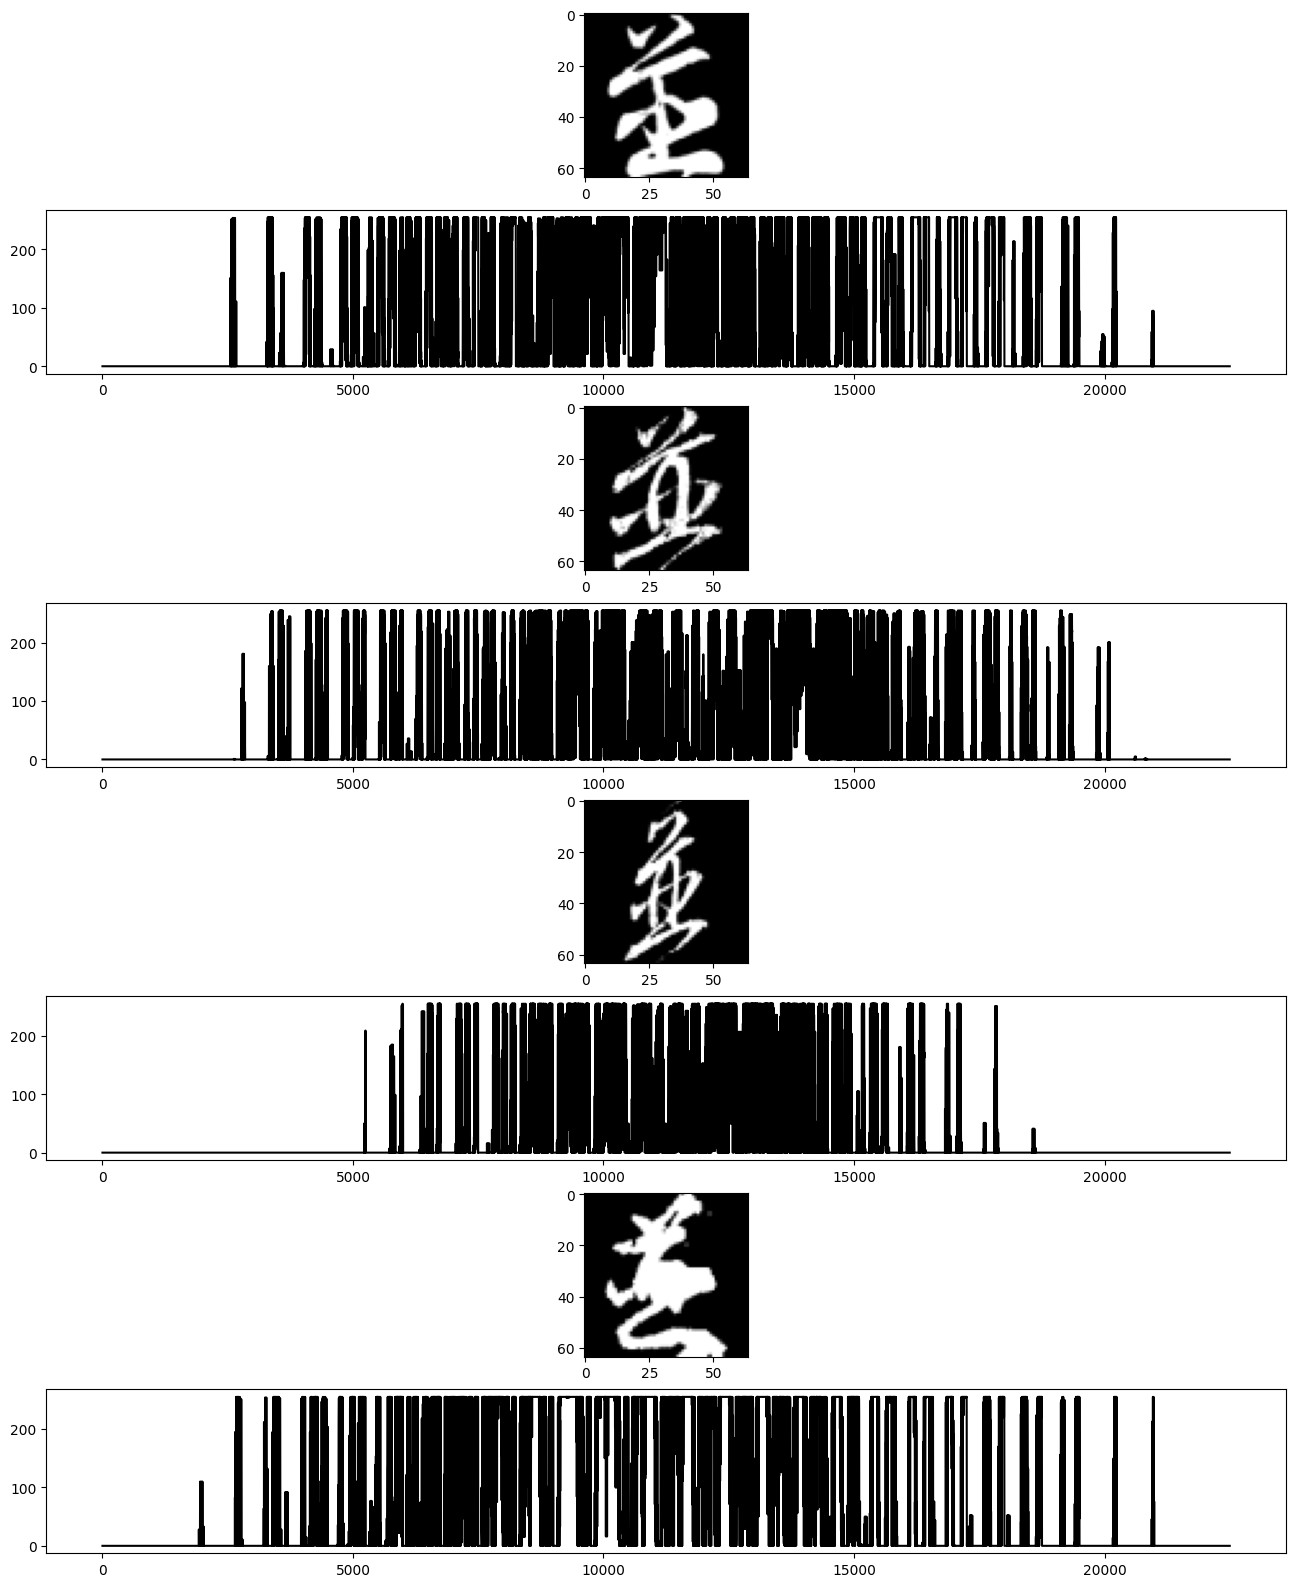

In [4]:
from matplotlib import pyplot as plt

image_path = "./kuzushiji-dataset/kkanji2/" + "U+4E26/0ed91c3052005a5c.png"
im2p = "./kuzushiji-dataset/kkanji2/" + "U+4E26/0f6d52f178177360.png"
im3p = "./kuzushiji-dataset/kkanji2/" + "U+4E26/3f38f66abe6e8829.png"
im4p = "./kuzushiji-dataset/kkanji2/" + "U+4E26/4b1f51176992c888.png"
# Load image...
image = plt.imread(image_path)
im2 = plt.imread(im2p)
im3 = plt.imread(im3p)
im4 = plt.imread(im4p)
print(image)
print(len(image))
print(len(image[0]))

plt.rcParams["figure.figsize"] = (16, 20)
plt.figure()

#subplot(r,c) provide the no. of rows and columns

f, axarr = plt.subplots(8,1) 


# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(image, cmap = "gray")

kernel = 5
stride = 2
output = generate_intersecting_locs(image, stride, kernel)
timeseries = transform_to_1d_no_rgb(output, image)

ax_x = []
for i in range(0, len(timeseries)):
    ax_x.append(i)

axarr[1].plot(ax_x, timeseries, "k", markersize = 0.1)

axarr[2].imshow(im2, cmap = "gray")
ts2 = transform_to_1d_no_rgb(generate_intersecting_locs(im2, stride, kernel), im2)
axarr[3].plot(ax_x, ts2, "k", markersize = 0.1)

axarr[4].imshow(im3, cmap = "gray")
ts3 = transform_to_1d_no_rgb(generate_intersecting_locs(im3, stride, kernel), im3)
axarr[5].plot(ax_x, ts3, "k", markersize = 0.1)

axarr[6].imshow(im4, cmap = "gray")
ts4 = transform_to_1d_no_rgb(generate_intersecting_locs(im4, stride, kernel), im4)
axarr[7].plot(ax_x, ts4, "k", markersize = 0.1)

img_width = 64
img_height = 64

grid_search_kernels = [2, 3, 4, 5, 6, 7]
grid_search_strides = [1, 2, 3, 4]
results = []
print("starting grid!")

'''
for kernel in grid_search_kernels:
    for stride in grid_search_strides:
        if stride >= kernel:
            continue
        path_arr = [] 
        output = generate_intersecting_locs(image, stride, kernel)
        path_arr.append(output)
        loss, _, _ = calc_min_loss(path_arr, 6, 6, img_width, img_height)
        kern_copy = copy.deepcopy(kernel)
        stride_copy = copy.deepcopy(stride)
        results.append([loss, kern_copy, stride_copy, len(path_arr[0])])
        print(f"Finished kern: {kernel}, stride: {stride}, loss: {loss}")
print(results)
new_file = open("./new_dataset_gridsearch.txt", "w")
new_file.write(f"{results}")
new_file.close()
'''

#